In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3476.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1613.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5593.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2975.BMP
/kaggle/input/finger-print-based-blood-g

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np 
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array,save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

2025-06-22 20:31:46.011457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750624306.429416      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750624306.545028      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
dataset_path= "/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory
dataset=image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(64,64),
    batch_size=32,
    shuffle=True
    )

Found 6000 files belonging to 8 classes.


I0000 00:00:1750624337.916521      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750624337.917209      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
class_names = dataset.class_names
class_counts = Counter()
for _,lables in dataset.unbatch():
    class_counts[int(lables.numpy())] += 1
    
print("Class Distribution:")
for i, count in class_counts.items():
    print(f"Class {class_names[i]}: {count} samples")

Class Distribution:
Class B-: 741 samples
Class A-: 1009 samples
Class O-: 712 samples
Class B+: 652 samples
Class A+: 565 samples
Class O+: 852 samples
Class AB-: 761 samples
Class AB+: 708 samples


In [8]:
import matplotlib.pyplot as plt
def plot_class_distribution(class_names, class_counts):
    classes=[class_names[i] for i in class_counts.keys()]
    counts=[class_counts[i] for i in class_counts.keys()]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color='skyblue', edgecolor='black') 
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(count), 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

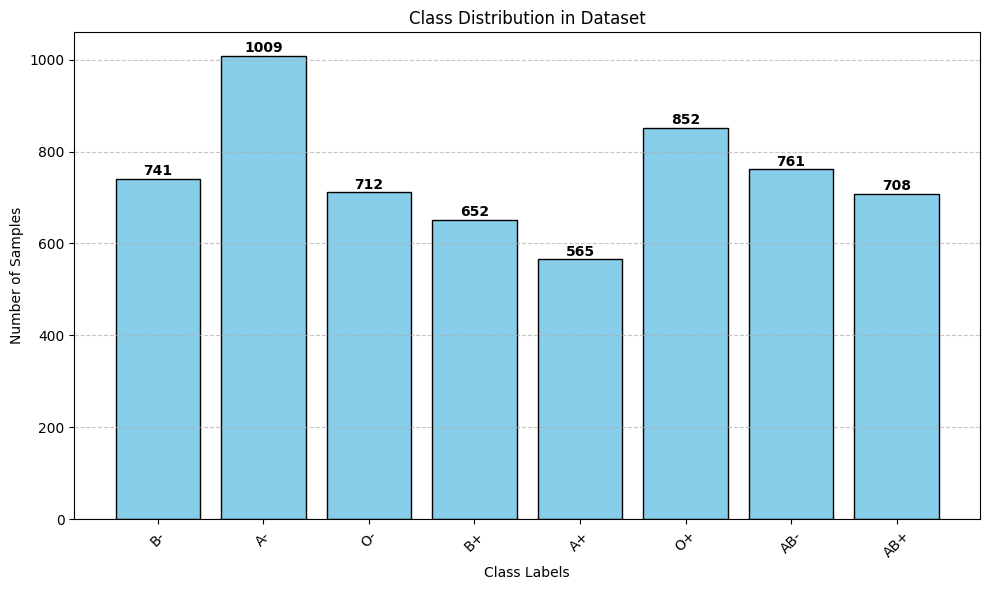

In [9]:
plot_class_distribution(class_names,class_counts)

In [10]:
max_count = max(class_counts.values())
def oversample_class(class_id, count, max_count):
    unbatched_dataset = dataset.unbatch()
    
    class_dataset = unbatched_dataset.filter(lambda _, lbl: tf.equal(lbl, class_id))
    
    repeat_factor = max_count // count + (max_count % count > 0)
    
    return class_dataset.repeat(repeat_factor).take(max_count)

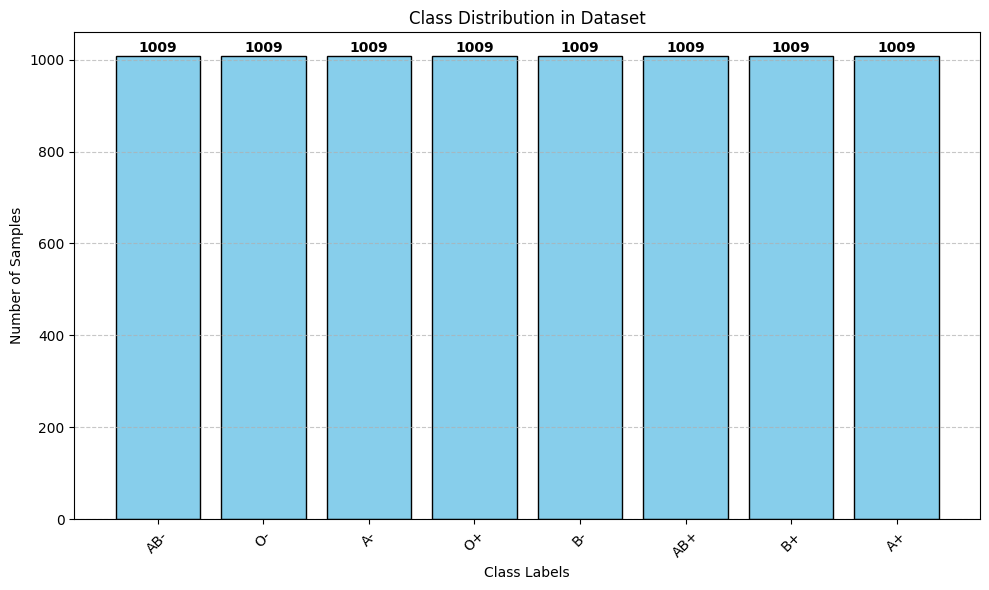

In [15]:
balanced_datasets=[]
BATCH_SIZE=32
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class( class_id, count,max_count))
    
balanced_dataset= tf.data.Dataset.sample_from_datasets(balanced_datasets)


balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)



In [16]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [21]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total samples in balanced dataset: {dataset_size}")

Total samples in balanced dataset: 8064


In [22]:
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

train_size=int(0.7 * dataset_size)
val_size=int(0.2 * dataset_size)

train_dataset= balanced_dataset_unbatched.take(train_size)
val_test_dataset= balanced_dataset_unbatched.skip(train_size)
val_dataset= val_test_dataset.take(val_size)
test_dataset= val_test_dataset.skip(val_size)

BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Number of train dataset: {train_batch_count * BATCH_SIZE}")
print(f"Number of validation dataset: {val_batch_count * BATCH_SIZE}")
print(f"Number of test dataset: {test_batch_count * BATCH_SIZE}")

Number of train dataset: 5632
Number of validation dataset: 1600
Number of test dataset: 800


In [23]:
def create_high_accuracy_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

high_acc_model= create_high_accuracy_model()

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', #
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6,
    
)

early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',          
    monitor='val_loss',                
    save_best_only=True,              
    save_weights_only=False,           
    mode='min',                       
    verbose=1
)

In [25]:
history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop, model_checkpoint]
    
)

Epoch 1/50


I0000 00:00:1750625249.692910     104 service.cc:148] XLA service 0x7d67e402bf90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750625249.699028     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750625249.699050     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750625250.395362     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


      3/Unknown 13s 67ms/step - accuracy: 0.0781 - loss: 398.0952

I0000 00:00:1750625258.501162     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    176/Unknown 30s 99ms/step - accuracy: 0.1440 - loss: 55.2813

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.98630, saving model to best_model.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 57s 252ms/step - accuracy: 0.1442 - loss: 55.0485 - val_accuracy: 0.2331 - val_loss: 1.9863 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3045 - loss: 1.8051
Epoch 2: val_loss improved from 1.98630 to 1.82225, saving model to best_model.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.3046 - loss: 1.8047 - val_accuracy: 0.4013 - val_loss: 1.8222 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4913 - loss: 1.3652
Epoch 3: val_loss improved from 1.82225 to 1.14304, saving model to best_model.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.4916 - loss: 1.3645 - val_accuracy: 0.6244 - val_loss: 1.1430 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6354 - loss: 1.0152
Epoch 4: val_loss improved from 1.14304 to 0.98727, saving mod

In [26]:
high_acc_model.save('model.h5')
print("Model saved as HDF5 format")

Model saved as HDF5 format


In [27]:
from IPython.display import FileLink
FileLink('model.h5')

/kaggle/working/model.h5

In [28]:
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9508 - loss: 0.2547
High Accuracy Model - Loss: 0.26406651735305786, Accuracy: 0.9487500190734863


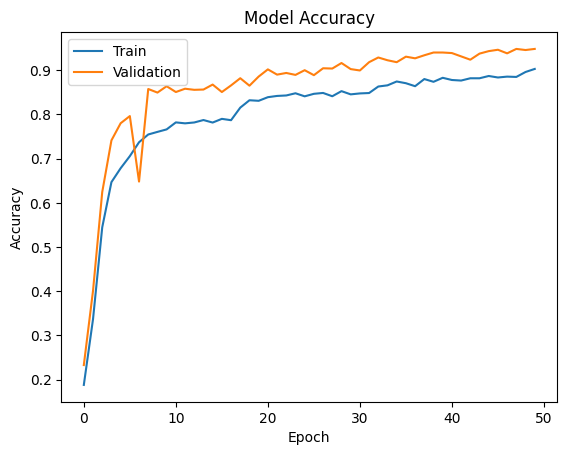

In [29]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classification Report:
              precision   

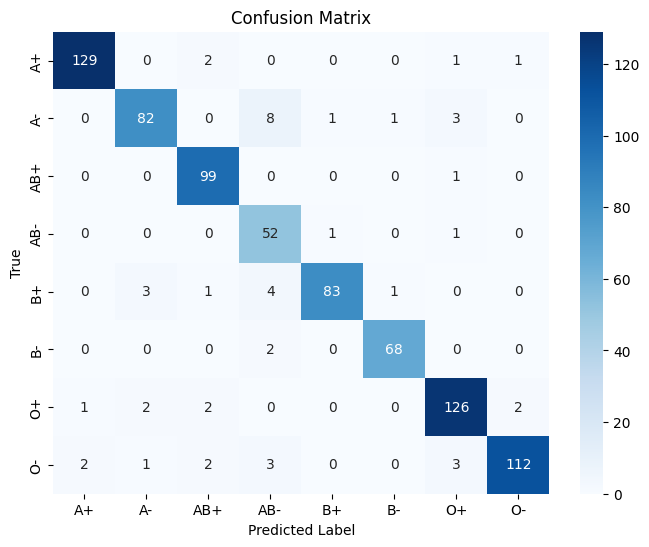

In [30]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)
    
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
    
report = classification_report(y_pred, y_true, target_names=class_names,)
print("Classification Report:")
print(report)
    
conf_matrix = confusion_matrix(y_true, y_pred)
    
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True')
plt.show()

In [31]:
import os
print(f"Model file size: {os.path.getsize('model.h5') / (1024**2):.2f} MB")

Model file size: 103.99 MB


In [32]:
print(dataset.class_names)

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [34]:
from collections import Counter

# If using image_dataset_from_directory
labels = np.concatenate([y for x, y in train_dataset], axis=0)
print(Counter(labels))

Counter({7: 759, 1: 737, 2: 724, 5: 705, 3: 704, 0: 678, 4: 667, 6: 658})
